<a href="https://colab.research.google.com/github/mc-robinson/RMD_colab_notebooks/blob/master/5_HT2B_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5-HT2B#

As used in [Ligand biological activity predicted by cleaning positive and negative chemical correlations](https://www.pnas.org/content/116/9/3373).

Now done with nested CV and more extensive hyperparameter optimization

In [0]:
!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y --prefix /usr/local -c rdkit rdkit

import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')

In [0]:
import PIL #needed for IPythonConsole

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole #needed to show molecules

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data_url = 'https://www.pnas.org/highwire/filestream/848445/field_highwire_adjunct_files/1/pnas.1810847116.sd01.xlsx'

actives_df = pd.read_excel(data_url, sheet_name='5-HT2b active')
actives_df.head()

,CANONICAL_SMILES,Unnamed: 1,Unnamed: 2,Unnamed: 3,Target,Source
0,CC(C)Cn1nc2ccc(cc2c1S(=O)(=O)c3cccc4ccccc34)N5...,NaN,NaN,NaN,5-HT2b,CHEMBL
1,COc1c(OCCF)cccc1[C@H](O)C2CCN(CCc3ccc(F)cc3)CC2,NaN,NaN,NaN,5-HT2b,CHEMBL
2,Clc1cccc(c1)N2CC[C@H]3CNC[C@@H]23,NaN,NaN,NaN,5-HT2b,CHEMBL
3,CC(C)(C)c1ccc(cc1)C(O)CCCN2CCC(CC2)C(O)(c3cccc...,NaN,NaN,NaN,5-HT2b,CHEMBL
4,CCCOc1cccc2C(=O)N3CCNC[C@H]3Cc12,NaN,NaN,NaN,5-HT2b,CHEMBL


In [0]:
active_mols = [Chem.MolFromSmiles(smi) for smi in list(actives_df['CANONICAL_SMILES'])]
active_fps_list = [np.array(x) for x in [AllChem.GetMorganFingerprintAsBitVect(y,3,1024) for y in active_mols]]
active_fps_arr = np.vstack(active_fps_list)

In [6]:
decoys_df = pd.read_excel(data_url, sheet_name='5-HT2b inactive')
decoys_df.head()

,CANONICAL_SMILES,Target,Source,ID
0,C(C(CO)O)NC(=O)c1c(c(c(c(c1I)N)I)C(=O)NCC(CO)O)I,5-HT2b,Pfizer,CMP_28814
1,C(CC(=O)O)C(=O)CN,5-HT2b,Pfizer,CMP_29033
2,C[C@]1(c2cccc(c2C(=O)C3=C([C@]4([C@@H]([C@H]([...,5-HT2b,Pfizer,CMP_28979
3,C[C@]12C[C@@H]([C@]3([C@H]([C@@H]1C[C@@H]4[C@]...,5-HT2b,Pfizer,CMP_28812
4,C[C@]12CC[C@@H](C([C@@H]1CC[C@@]3([C@@H]2CC=C4...,5-HT2b,Pfizer,CMP_28493


In [0]:
decoy_mols = [Chem.MolFromSmiles(smi) for smi in list(decoys_df['CANONICAL_SMILES'])]
decoy_fps_list = [np.array(x) for x in [AllChem.GetMorganFingerprintAsBitVect(y,3,1024) for y in decoy_mols]]
decoy_fps_arr = np.vstack(decoy_fps_list)

In [0]:
X = np.concatenate((active_fps_arr,decoy_fps_arr),axis=0)
y = np.concatenate((np.ones(active_fps_arr.shape[0]), np.zeros(decoy_fps_arr.shape[0])))

In [9]:
print(f'fingerprint length: {X.shape[1]}')
print(f'number of actives: {y[y==1].shape[0]}')
print(f'number of decoys: {y[y==0].shape[0]}')

fingerprint length: 1024
number of actives: 847
number of decoys: 364


In [10]:
!git clone https://github.com/mc-robinson/RMD_colab_notebooks.git

Cloning into 'RMD_colab_notebooks'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [0]:
!cp RMD_colab_notebooks/chem_rmd.py .

In [0]:
def classical_AUC_CI(AUC, n_actives, n_inactives):
    import scipy.stats
    
    var_active = ((AUC**2)*(1-AUC)/(1+AUC))/n_actives
    var_inactive = (AUC*((1-AUC)**2)/(2-AUC))/n_inactives
    
    df_eff = (
        (((var_active/n_actives)+(var_inactive/n_inactives))**2) / 
        (
            (((var_active/n_actives)**2)/(n_actives-1)) +
            (((var_inactive/n_inactives)**2)/(n_inactives-1))
        )
    )
    
    std_error = np.sqrt(var_active+var_inactive)
    
    logit_auc = np.log(AUC/(1-AUC))
    logit_std_error = std_error * (1/(AUC*(1-AUC)))
    
    t_95 = scipy.stats.t.ppf(0.975,df_eff)
    logit_lower_limit = logit_auc - t_95*logit_std_error
    logit_upper_limit = logit_auc + t_95*logit_std_error
    
    lower_limit = 1/(1+np.exp(-1*logit_lower_limit))
    upper_limit = 1/(1+np.exp(-1*logit_upper_limit))
    
    return lower_limit, upper_limit


In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

def plot_roc_curves(y_test, y_scores, title='ROC curves'):

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure(figsize=(6,4))
    for i in range(len(y_scores)):
        # Compute ROC curve and area the curve
        scores = y_scores[i]
        classes = y_test[i]
        fpr, tpr, thresholds = roc_curve(classes, scores)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='Run %d (AUC = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    #print('mean auc', np.mean(aucs))
    if len(y_scores) > 1:
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')
    else:    
        n_actives = sum(y_test[y_test==1])
        n_inactives = sum(y_test[y_test==0])
        AUC_CI_lower, AUC_CI_upper = classical_AUC_CI(aucs[0],
                                                      n_actives,
                                                      n_inactives)
        plt.text(0.33,0.2,f'AUC CI from formula {round(AUC_CI_lower,3),round(AUC_CI_upper,3)}')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='upper center', bbox_to_anchor=(1.4, 1.0), shadow=True, ncol=1)
    plt.show()

In [0]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curves(y_test, y_scores, title='PR Curves'):

    precisions = []
    aucs = []
    mean_recall = np.linspace(0, 1, 100)

    plt.figure(figsize=(6,4))

    for i in range(len(y_scores)):
        scores = y_scores[i]
        classes = y_test[i]
        precision, recall, thresholds = precision_recall_curve(classes, scores)
        avg_precision = average_precision_score(classes, scores)
        aucs.append(avg_precision)
        #aucs.append(auc(recall, precision))
        plt.step(recall, precision, color='b', alpha=0.2,
             where='post',label='Run %d (AUC = %0.2f)' % (i, avg_precision))

        i += 1

    if len(y_scores)>1:
        print('MEAN PR-AUC:', np.mean(aucs))
        print('STD PR-AUC:', np.std(aucs))
        std_auc = np.std(aucs)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1), shadow=True, ncol=1)
    plt.show()

### Perform Nested Cross Validation On Each Algorithm ###

To be extra safe that the dataframe is not ordered in a way that could bias the data, first shuffle the data. Note that every random state in this dataset will be set to 42, to maintain reproducibility. 

In [0]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)

# RMD # 

In [0]:
from chem_rmd import RMD
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

def rmd_GridSearchCV(X, y, n_folds=5):
    
    scoring_list = ['theoretical', 'basic', 'weighted',
                    'dist_to_positive', 'dist_to_negative']
    scoring_dict = dict.fromkeys(scoring_list, 0)

    for scoring in scoring_list:
        sss = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=False)
        for train_index, test_index in sss.split(X, y): 
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            rmd = RMD()
            rmd.fit(X_train, y_train)
            y_pred = rmd.predict_scores(X_test,scoring=scoring )
            metric = roc_auc_score(y_test, y_pred)
            scoring_dict[scoring] = scoring_dict[scoring] + metric/n_folds
    
    #scoring_dict = {k,(v/n_folds) for k,v in scoring_dict.items()}
    best_scoring = [k for k,v in scoring_dict.items() if v==max(scoring_dict.values())][0]
    return best_scoring, scoring_dict

In [0]:
# nested CV

def nested_RMD_CV(X, y, n_outer_folds=5, n_inner_folds=4, verbose=True):
    
    y_test_list = []
    y_pred_list = []
    # Perform Outer CV Loop
    sss = StratifiedKFold(n_splits=n_outer_folds, random_state=42,
                          shuffle=False)
    for train_index, test_index in sss.split(X, y): 
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # inner loop
        best_scoring, _ = rmd_GridSearchCV(X_train, y_train,
                                           n_folds=n_inner_folds)
        
        # retrain best classifier on all of X_train, y_train
        rmd = RMD()
        rmd.fit(X_train, y_train)
        
        # test on outer test fold
        rmd_scores = rmd.predict_scores(X_test, scoring=best_scoring)
        metric = roc_auc_score(y_test, rmd_scores)
        
        y_test_list.append(y_test)
        y_pred_list.append(rmd_scores)
        
        if verbose:
            print('Best parameter value: ', best_scoring)
            print('ROC-AUC: ', metric)
        
    return y_test_list, y_pred_list

    

In [18]:
%%time
y_test_list, rmd_pred_list = nested_RMD_CV(X, y)

Best parameter value:  theoretical
ROC-AUC:  0.9634971796937953
Best parameter value:  basic
ROC-AUC:  0.9500402900886382
Best parameter value:  basic
ROC-AUC:  0.9349112426035502
Best parameter value:  theoretical
ROC-AUC:  0.9631190727081139
Best parameter value:  basic
ROC-AUC:  0.9700854700854701
CPU times: user 9min 2s, sys: 2min 52s, total: 11min 55s
Wall time: 6min


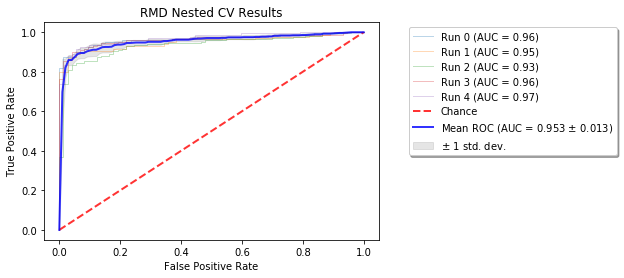

In [19]:
plot_roc_curves(y_test_list, rmd_pred_list, 'RMD Nested CV Results')

MEAN PR-AUC: 0.9833859179819203
STD PR-AUC: 0.005442139700542528


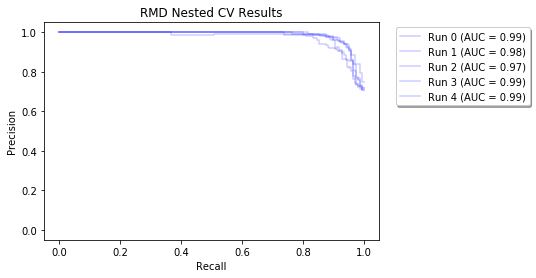

In [20]:
plot_pr_curves(y_test_list, rmd_pred_list, 'RMD Nested CV Results')

In [0]:
def nested_cv(X, y, clf, param_grid, n_jobs=-1, 
              n_outer_folds=5, n_inner_folds=4, verbose=0):
    
    from sklearn.model_selection import GridSearchCV
    
    y_test_list = []
    y_pred_list = []
    # Perform Outer CV Loop
    sss = StratifiedKFold(n_splits=n_outer_folds, random_state=42,
                          shuffle=False)
    for train_index, test_index in sss.split(X, y): 
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # inner loop
        # need to create own cv generator so set random state
        inner_cv =  StratifiedKFold(n_splits=n_inner_folds, random_state=42,
                                    shuffle=False)
        grid = GridSearchCV(clf,
                            cv=inner_cv,
                            n_jobs=n_jobs,
                            verbose=verbose,
                            param_grid=param_grid,
                            scoring='roc_auc')
        grid.fit(X_train, y_train)
        
        # retrain best classifier on all of X_train, y_train
        best_clf = grid.best_estimator_
        best_clf.fit(X_train, y_train)
        
        # test on outer test fold
        try:
            best_clf_scores = best_clf.decision_function(X_test)
        except(NotImplementedError, AttributeError):
            best_clf_scores = best_clf.predict_proba(X_test)[:,1]
            
        metric = roc_auc_score(y_test, best_clf_scores)
        
        y_test_list.append(y_test)
        y_pred_list.append(best_clf_scores)
        
        if verbose == 0:
            print('Best parameter values: ', grid.best_params_)
            print('Outer fold ROC-AUC: ', metric)
        
    return y_test_list, y_pred_list

# NB

In [22]:
%%time
from sklearn.naive_bayes import BernoulliNB

nb = BernoulliNB()
alpha_range = np.arange(0.0, 2, 0.1)
nb_param_grid = dict(alpha=alpha_range)

y_test_list, nb_pred_list = nested_cv(X, y, nb, nb_param_grid, n_jobs=-1, 
                                        n_outer_folds=5, n_inner_folds=4, verbose=0)

Best parameter values:  {'alpha': 0.2}
Outer fold ROC-AUC:  0.9285253827558422
Best parameter values:  {'alpha': 0.8}
Outer fold ROC-AUC:  0.9117647058823529
Best parameter values:  {'alpha': 1.0}
Outer fold ROC-AUC:  0.9011104806679096
Best parameter values:  {'alpha': 0.6000000000000001}
Outer fold ROC-AUC:  0.9369376671800277
Best parameter values:  {'alpha': 0.2}
Outer fold ROC-AUC:  0.9347468770545694
CPU times: user 992 ms, sys: 331 ms, total: 1.32 s
Wall time: 20.2 s


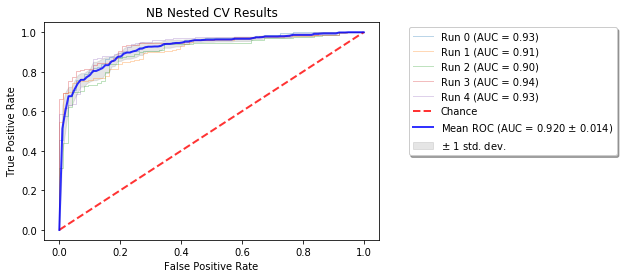

In [23]:
plot_roc_curves(y_test_list, nb_pred_list, 'NB Nested CV Results')

MEAN PR-AUC: 0.9675220842357156
STD PR-AUC: 0.006519777180589182


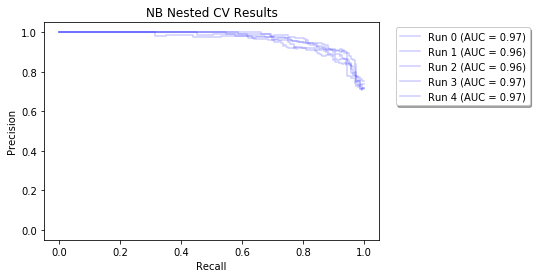

In [24]:
plot_pr_curves(y_test_list, nb_pred_list, 'NB Nested CV Results')

# KNN

In [25]:
%%time
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
neighbors_range = np.arange(2,8,1)
weights_range = ['uniform','distance']
knn_param_grid = dict(n_neighbors=neighbors_range, weights=weights_range)

y_test_list, knn_pred_list = nested_cv(X, y, knn, knn_param_grid, n_jobs=-1, 
                                        n_outer_folds=5, n_inner_folds=4, verbose=0)

Best parameter values:  {'n_neighbors': 7, 'weights': 'distance'}
Outer fold ROC-AUC:  0.9657534246575343
Best parameter values:  {'n_neighbors': 7, 'weights': 'distance'}
Outer fold ROC-AUC:  0.9594278807413376
Best parameter values:  {'n_neighbors': 7, 'weights': 'distance'}
Outer fold ROC-AUC:  0.9422874280619276
Best parameter values:  {'n_neighbors': 7, 'weights': 'distance'}
Outer fold ROC-AUC:  0.9663613520304775
Best parameter values:  {'n_neighbors': 7, 'weights': 'distance'}
Outer fold ROC-AUC:  0.9511834319526629
CPU times: user 3.92 s, sys: 78.3 ms, total: 4 s
Wall time: 3min 51s


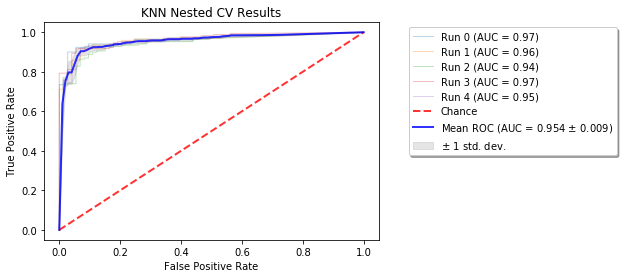

In [26]:
plot_roc_curves(y_test_list, knn_pred_list, 'KNN Nested CV Results')

MEAN PR-AUC: 0.9809743596809491
STD PR-AUC: 0.006044402762702019


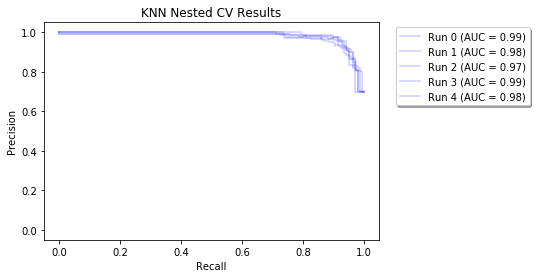

In [27]:
plot_pr_curves(y_test_list, knn_pred_list, 'KNN Nested CV Results')

# RF

In [28]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
n_estimators_range = [1000]
max_features_range = int(np.sqrt(X.shape[1])) * np.array([1,2,3])
rf_param_grid = dict(n_estimators=n_estimators_range,
                  max_features=max_features_range)

y_test_list, rf_pred_list = nested_cv(X, y, rf, rf_param_grid, n_jobs=-1, 
                                        n_outer_folds=5, n_inner_folds=4, verbose=0)

Best parameter values:  {'max_features': 32, 'n_estimators': 1000}
Outer fold ROC-AUC:  0.9724415793714746
Best parameter values:  {'max_features': 32, 'n_estimators': 1000}
Outer fold ROC-AUC:  0.9536261079774375
Best parameter values:  {'max_features': 32, 'n_estimators': 1000}
Outer fold ROC-AUC:  0.9460565777741752
Best parameter values:  {'max_features': 32, 'n_estimators': 1000}
Outer fold ROC-AUC:  0.9804247385912297
Best parameter values:  {'max_features': 32, 'n_estimators': 1000}
Outer fold ROC-AUC:  0.9670857988165681
CPU times: user 33.1 s, sys: 116 ms, total: 33.2 s
Wall time: 3min 25s


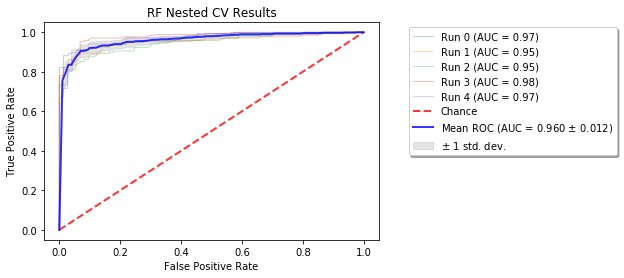

In [29]:
plot_roc_curves(y_test_list, rf_pred_list, 'RF Nested CV Results')

MEAN PR-AUC: 0.9859296452686566
STD PR-AUC: 0.004570616989261151


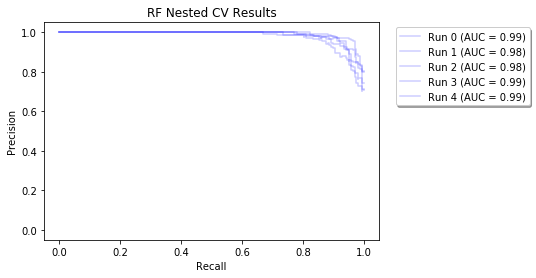

In [30]:
plot_pr_curves(y_test_list, rf_pred_list, 'RF Nested CV Results')

# SVM

In [31]:
%%time

from sklearn.svm import SVC

svm = SVC()
C_range = 10. ** np.arange(-1, 3, 1)
gamma_range = 10. ** np.arange(-3, 2, 2)
svm_param_grid = dict(gamma=gamma_range, C=C_range)

y_test_list, svm_pred_list = nested_cv(X, y, svm, svm_param_grid, n_jobs=-1, 
                                        n_outer_folds=5, n_inner_folds=4, verbose=0)

Best parameter values:  {'C': 10.0, 'gamma': 0.1}
Outer fold ROC-AUC:  0.9676067687348912
Best parameter values:  {'C': 10.0, 'gamma': 0.1}
Outer fold ROC-AUC:  0.9423045930701047
Best parameter values:  {'C': 10.0, 'gamma': 0.1}
Outer fold ROC-AUC:  0.9523384939612548
Best parameter values:  {'C': 10.0, 'gamma': 0.1}
Outer fold ROC-AUC:  0.9657939531490638
Best parameter values:  {'C': 10.0, 'gamma': 0.1}
Outer fold ROC-AUC:  0.9700854700854701
CPU times: user 17.7 s, sys: 102 ms, total: 17.8 s
Wall time: 3min 54s


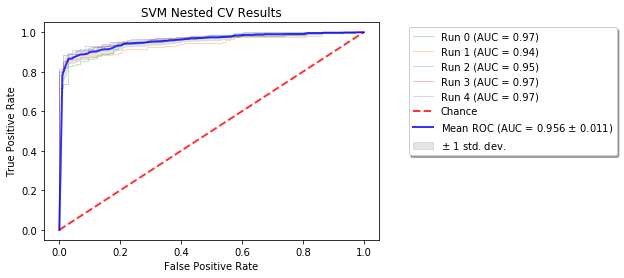

In [32]:
plot_roc_curves(y_test_list, svm_pred_list, 'SVM Nested CV Results')

MEAN PR-AUC: 0.9846756033160533
STD PR-AUC: 0.0038220184793541744


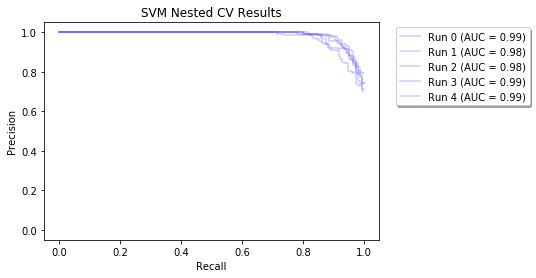

In [33]:
plot_pr_curves(y_test_list, svm_pred_list, 'SVM Nested CV Results')

# DNN

Note that this will not involve nested-CV, because no hyperparameter optimization will be done for ease of implementation. Sensible default values will be chosen and used across all folds

In [0]:
import torch
import fastai
from fastai.tabular import *

In [0]:
import torch.nn as nn
import torch.nn.functional as F

def bn_drop_lin(n_in:int, n_out:int, bn:bool=True,
                p:float=0., actn:Optional[nn.Module]=None):
    "`n_in`->bn->dropout->linear(`n_in`,`n_out`)->`actn`"
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

class Simple_DNN(nn.Module):
    def __init__(self, n_in, n_hidden=[512, 512, 512], n_out=2, dropout=0.5):
        super(Simple_DNN, self).__init__()
    
        layers = []
        layers += bn_drop_lin(n_in, n_hidden[0],
                              bn=False, p=0.0,
                              actn=nn.ReLU(inplace=True))
        for i in range(len(n_hidden)-1):
            layers += bn_drop_lin(n_hidden[i], n_hidden[i+1],
                                bn=False, p=dropout,
                                actn=nn.ReLU(inplace=True))
        layers += bn_drop_lin(n_hidden[-1], n_out,
                                bn=False, p=dropout,
                                actn=None)
    
        self.layers = nn.Sequential(*layers)
    
    def forward(self, xb):
        xb = self.layers(xb)
        return xb

In [0]:
def dnn_cv(X, y, n_outer_folds=5, verbose=True):
    
    y_test_list = []
    y_pred_list = []
    # Perform Outer CV Loop
    sss = StratifiedKFold(n_splits=n_outer_folds, random_state=42,
                          shuffle=False)
    for train_index, test_index in sss.split(X, y): 
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # convert to pytorch tensors
        X_train, y_train, X_test, y_test = \
        map(
          partial(torch.tensor, dtype=torch.float),
          (X_train, y_train, X_test, y_test)
        )
        y_train = y_train.long()
        y_test = y_test.long()

        # construct pytorch datasets
        train_ds = TensorDataset(X_train, y_train)
        test_ds = TensorDataset(X_test, y_test)

        # construct fastai databunch
        bs = 64
        data = DataBunch.create(train_ds, test_ds, bs=bs)
        
        # define and train dnn
        learn = Learner(data,
                Simple_DNN(n_in=X_train.shape[1],
                           n_hidden=[64,64],
                           n_out=2,
                           dropout=0.5),
                loss_func=CrossEntropyFlat())
        
        learn.fit_one_cycle(10, 1e-03)
        learn.fit_one_cycle(5, 1e-05)
        
        dnn_log_probs = get_preds(learn.model, data.valid_dl)[0]
        dnn_scores = np.exp(dnn_log_probs[:,1])
        
        metric = roc_auc_score(y_test, dnn_scores)
        
        y_test_list.append(y_test.numpy())
        y_pred_list.append(dnn_scores.numpy())
        
        if verbose:
            print('ROC-AUC: ', metric)
        
    return y_test_list, y_pred_list

In [37]:
%%time
y_test_list, dnn_pred_list = dnn_cv(X, y, n_outer_folds=5, verbose=True)

ROC-AUC:  0.9409927679158449
CPU times: user 7.56 s, sys: 4.81 s, total: 12.4 s
Wall time: 19.3 s


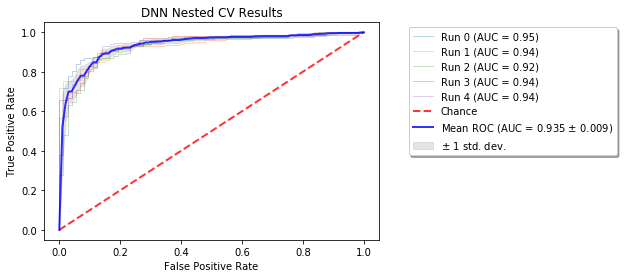

In [38]:
from sklearn.metrics import roc_curve, auc # b/c fastai was overwriting a metric
plot_roc_curves(y_test_list, dnn_pred_list, 'DNN Nested CV Results')

MEAN PR-AUC: 0.9734447163473885
STD PR-AUC: 0.004962757603668432


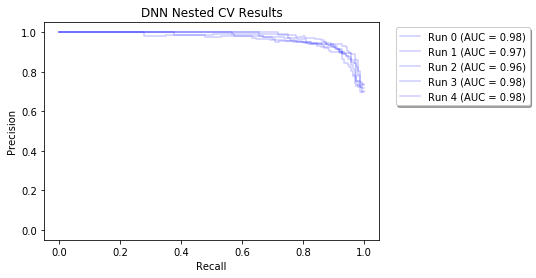

In [39]:
plot_pr_curves(y_test_list, dnn_pred_list, 'DNN Nested CV Results')

# How Similar Are the Methods? #

In [0]:
num_scores = len(rmd_pred_list[0].argsort().argsort())
test0_ranks_df = pd.DataFrame({
                                'rmd': num_scores - rmd_pred_list[0].argsort().argsort(),
                                'knn': num_scores - knn_pred_list[0].argsort().argsort(),
                                'nb': num_scores - nb_pred_list[0].argsort().argsort(),
                                'rf': num_scores - rf_pred_list[0].argsort().argsort(),
                                'svm': num_scores - svm_pred_list[0].argsort().argsort(),
                                'dnn': num_scores - dnn_pred_list[0].argsort().argsort(),
                            })

### Let's plot how the compounds rank each compound, and see how correlated the methods are. Compounds at low ranks are those judged to be most likely to be active by the classifier.

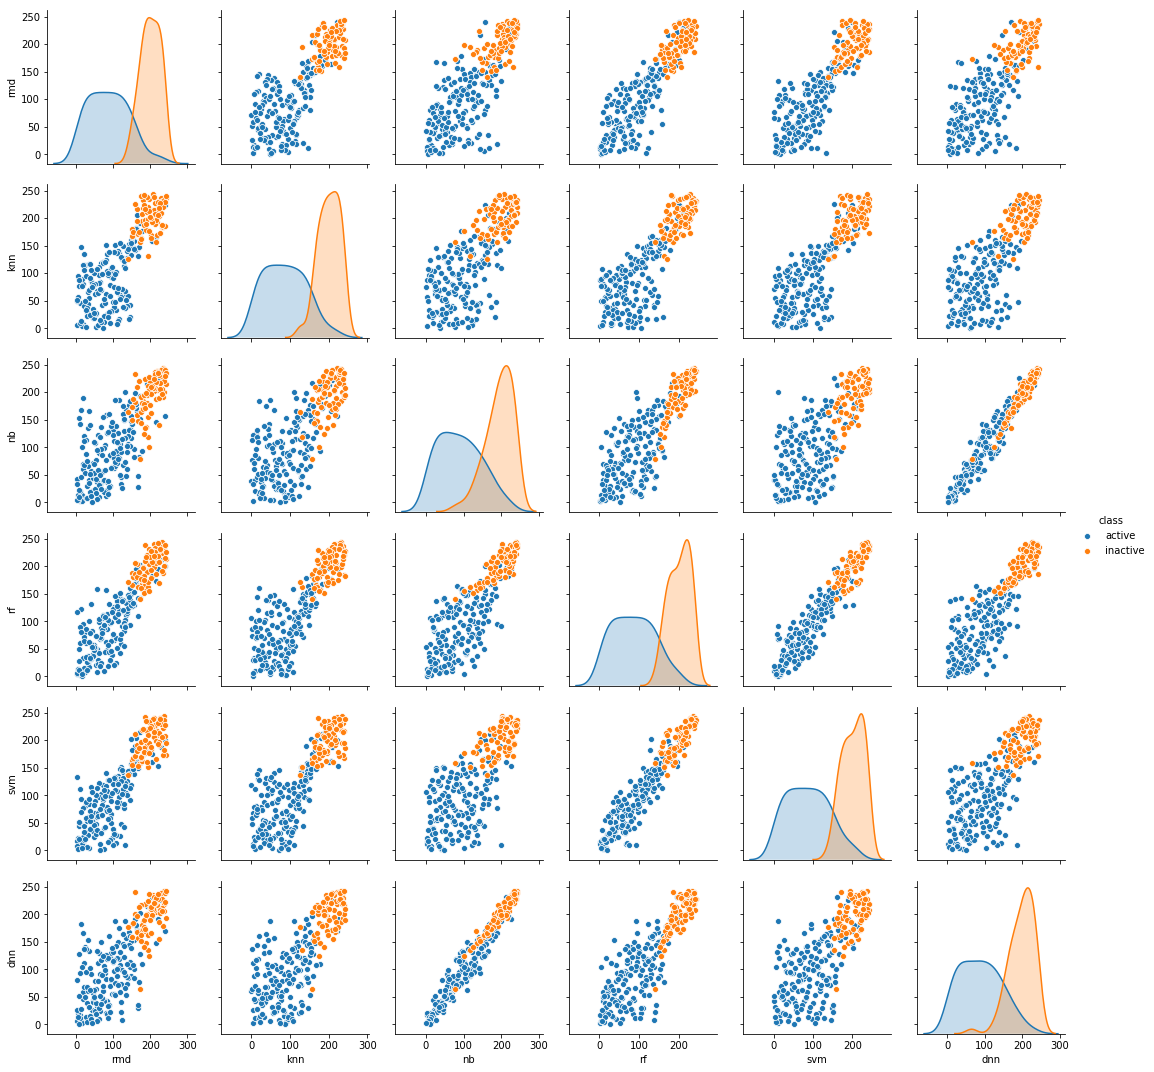

In [41]:
import seaborn as sns

test0_ranks_df['class'] = y_test_list[0]
test0_ranks_df['class'] = test0_ranks_df['class'].apply(lambda x: 'active' if x==1 else 'inactive')
sns.pairplot(test0_ranks_df, hue='class')

### Let's do it for one more test set:

In [0]:
num_scores = len(rmd_pred_list[0].argsort().argsort())
test5_ranks_df = pd.DataFrame({
                                'rmd': num_scores - rmd_pred_list[-1].argsort().argsort(),
                                'knn': num_scores - knn_pred_list[-1].argsort().argsort(),
                                'nb': num_scores - nb_pred_list[-1].argsort().argsort(),
                                'rf': num_scores - rf_pred_list[-1].argsort().argsort(),
                                'svm': num_scores - svm_pred_list[-1].argsort().argsort(),
                                'dnn': num_scores - dnn_pred_list[-1].argsort().argsort(),
                            })

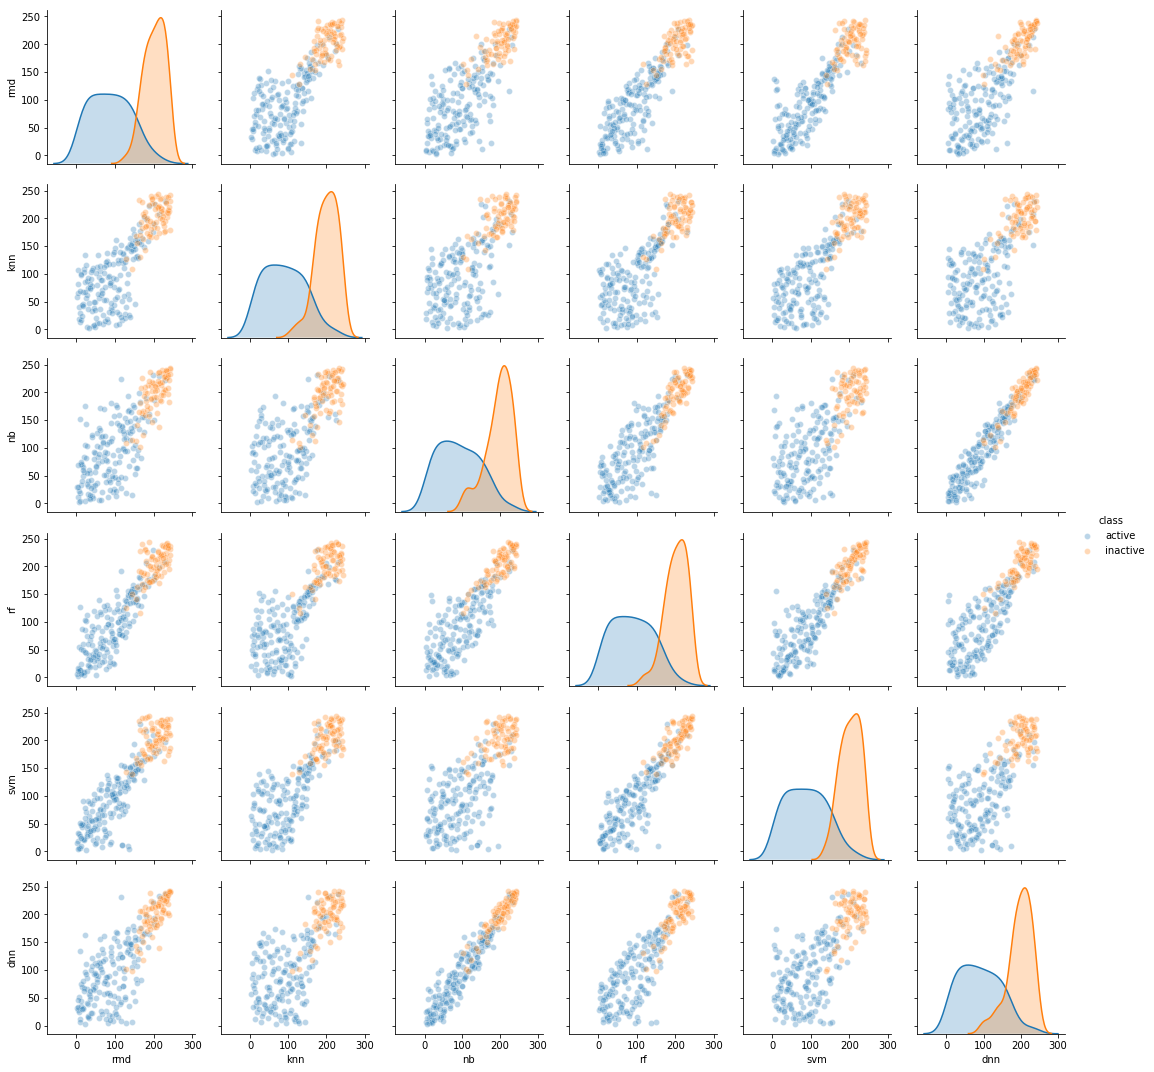

In [43]:
test5_ranks_df['class'] = y_test_list[-1]
test5_ranks_df['class'] = test5_ranks_df['class'].apply(lambda x: 'active' if x==1 else 'inactive')
sns.pairplot(test5_ranks_df, hue='class', plot_kws={'alpha':0.3} )

### Look how similar the NB and DNN predictions are in both cases. Furthermroe, the RF and SVM predictions are very similar

### The algorithms are still a bit uncorrelated, let's see if we can help by using a voting classifier:

In [0]:
voting_aucs_list = []
for i in range(len(y_test_list)):
    vote_ranks_arr = np.vstack((rmd_pred_list[i].argsort().argsort(),
                             knn_pred_list[i].argsort().argsort(),
                             nb_pred_list[i].argsort().argsort(),
                             rf_pred_list[i].argsort().argsort(),
                             svm_pred_list[i].argsort().argsort(),
                             dnn_pred_list[i].argsort().argsort()))
    vote_pred = np.mean(vote_ranks_arr, axis=0)
    
    voting_aucs_list.append(roc_auc_score(y_test_list[i], vote_pred))

In [45]:
voting_aucs_list

[0.9731265108783239,
 0.9575342465753425,
 0.9485288157574776,
 0.9792088838453432,
 0.9696745562130178]

In [46]:
np.mean(voting_aucs_list)

0.9656146026539009

In [47]:
np.std(voting_aucs_list)

0.011089930003499827

In [0]:
X_test_list = []
sss = StratifiedKFold(n_splits=5, random_state=42,
                          shuffle=False)
for train_index, test_index in sss.split(X, y): 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_test_list.append(X_test)

In [0]:
def tanimoto(v1, v2):
    """
    Calculates tanimoto similarity for two bit vectors
    """
    return(np.bitwise_and(v1, v2).sum() / np.bitwise_or(v1, v2).sum())

dists = []
fps = X_test_list[0]
activity = y_test_list[0]
active_fps = fps[activity==1]
nfps = active_fps.shape[0]

fp_sims_list = []
for i in range(nfps):
    sims = []
    for j in range(nfps):
        if i != j:
            sims.append(tanimoto(active_fps[i], active_fps[j]))
    fp_sims_list.append(np.mean(sims))

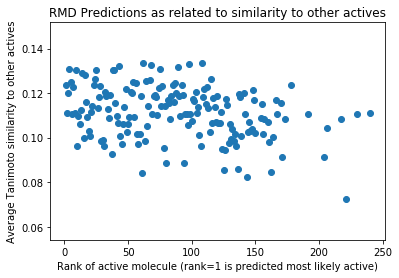

In [50]:
plt.scatter(num_scores - rmd_pred_list[0].argsort().argsort()[activity==1], fp_sims_list)
plt.xlabel('Rank of active molecule (rank=1 is predicted most likely active)')
plt.ylabel('Average Tanimoto similarity to other actives')
plt.title('RMD Predictions as related to similarity to other actives');

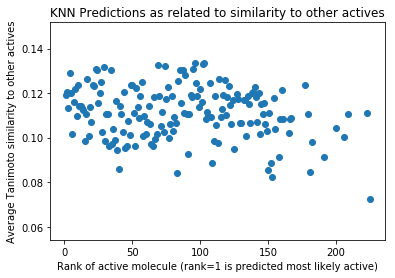

In [51]:
plt.scatter(num_scores - knn_pred_list[0].argsort().argsort()[activity==1], fp_sims_list)
plt.xlabel('Rank of active molecule (rank=1 is predicted most likely active)')
plt.ylabel('Average Tanimoto similarity to other actives')
plt.title('KNN Predictions as related to similarity to other actives');

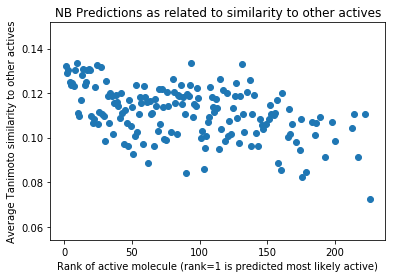

In [52]:
plt.scatter(num_scores - nb_pred_list[0].argsort().argsort()[activity==1], fp_sims_list)
plt.xlabel('Rank of active molecule (rank=1 is predicted most likely active)')
plt.ylabel('Average Tanimoto similarity to other actives')
plt.title('NB Predictions as related to similarity to other actives');

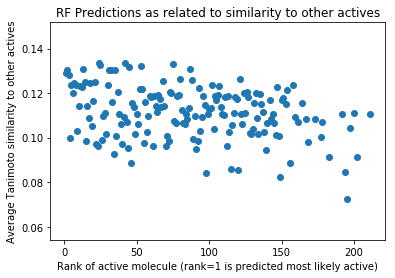

In [53]:
plt.scatter(num_scores - rf_pred_list[0].argsort().argsort()[activity==1], fp_sims_list)
plt.xlabel('Rank of active molecule (rank=1 is predicted most likely active)')
plt.ylabel('Average Tanimoto similarity to other actives')
plt.title('RF Predictions as related to similarity to other actives');

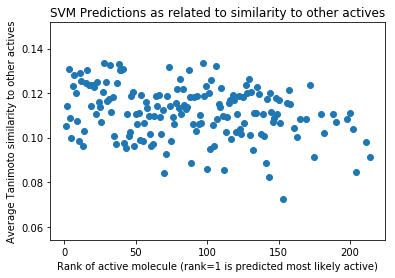

In [54]:
plt.scatter(num_scores - svm_pred_list[0].argsort().argsort()[activity==1], fp_sims_list)
plt.xlabel('Rank of active molecule (rank=1 is predicted most likely active)')
plt.ylabel('Average Tanimoto similarity to other actives')
plt.title('SVM Predictions as related to similarity to other actives');

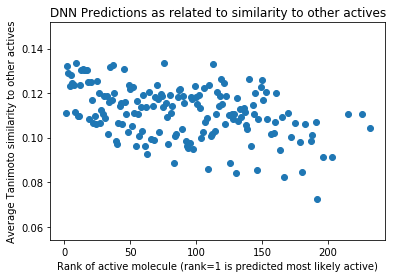

In [55]:
plt.scatter(num_scores - dnn_pred_list[0].argsort().argsort()[activity==1], fp_sims_list)
plt.xlabel('Rank of active molecule (rank=1 is predicted most likely active)')
plt.ylabel('Average Tanimoto similarity to other actives')
plt.title('DNN Predictions as related to similarity to other actives');